In [298]:
import pandas as pd
import requests
from bs4 import BeautifulSoup as bf
from datetime import datetime
import calendar
from collections import Counter
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

In [299]:
# Make all my plots 538 Style
plt.style.use('fivethirtyeight')

# Getting Data

In [2]:
url = 'http://web.mta.info/developers/turnstile.html'
mta_page = bf(requests.get(url).text, 'lxml')

In [8]:
data = pd.read_csv('http://web.mta.info/developers/data/nyct/turnstile/turnstile_160917.txt')

In [9]:
count = 0
for i in mta_page.find('div', class_="span-84 last").find_all('a')[:100]:
    count += 1
    data = pd.concat([data, pd.read_csv('http://web.mta.info/developers/' + str(i.get('href')))])
    if count % 25 == 0: print count

25
50
75
100


In [12]:
data.to_csv('mta_data.csv')

# Cleaning Data

In [37]:
data.columns = [i.lower().strip() for i in data.columns]

In [21]:
data = data.reset_index(drop = True)

In [28]:
data.date = [datetime.strptime(i, '%m/%d/%Y') for i in data.date]

## Feature Engineering

In [88]:
data['month'] = [i.strftime('%b') for i in data.date]
data['year'] = [i.year for i in data.date]
data['day'] = [i.day for i in data.date]
data['day_of_week'] = [calendar.day_name[i.weekday()] for i in data.date]

weekend = ['Saturday', 'Sunday']
data['weekend'] = [1 if i in weekend else 0 for i in data.day_of_week]
data['time_int'] = [int(i.split(':')[0]) for i in data.time]

In [248]:
# Getting the Season
def get_season(date):
    year = date.year
    seasons = {'Summer':(datetime(year,6,1), datetime(year,8,31)),
           'Autumn':(datetime(year,9,1), datetime(year,11,30)),
           'Spring':(datetime(year,3,1), datetime(year,5,31))}
            
    for season,(season_start, season_end) in seasons.items():
        if date>=season_start and date<= season_end:
            return season
    else:
        return 'Winter'
    
data['season'] = [get_season(i) for i in data.date]

In [249]:
# Taking out the Anomalies
exits = data.exits
entries = data.entries

net_exits = exits[1:].values - exits[:-1].values
net_entries = entries[1:].values - entries[:-1].values

abs_net_exits =   np.abs(exits[1:].values - exits[:-1].values)
abs_net_entries = np.abs(entries[1:].values - entries[:-1].values)

net_data = data.copy().loc[1:]
net_data['abs_net_entries'] = abs_net_entries
net_data['abs_net_exits'] =   abs_net_exits
net_data['abs_net_entries'] = abs_net_entries
net_data['abs_net_exits'] =   abs_net_exits

In [253]:
final_data = net_data.copy()[net_data.abs_net_entries < 4000]

# Exploration
## Entries By:

### Weekday

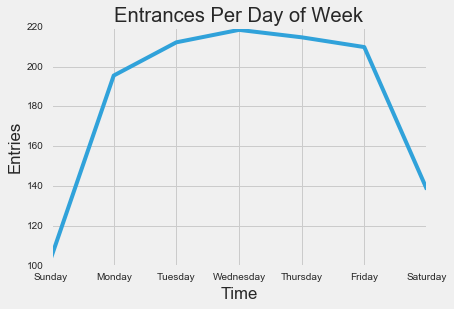

In [315]:
day = ['Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday']
final_data.groupby('day_of_week').mean()['abs_net_entries'][day].plot()
plt.title('Entrances Per Day of Week')
plt.xlabel('Time')
plt.ylabel('Entries')
print ''

There is much more traffic on the workweeks with Wednesday getting the most traffic of the week. <br>
<b>So I'll see the entries first per workweek and then for the weekends.</b>

# Workweek

### Time of Day

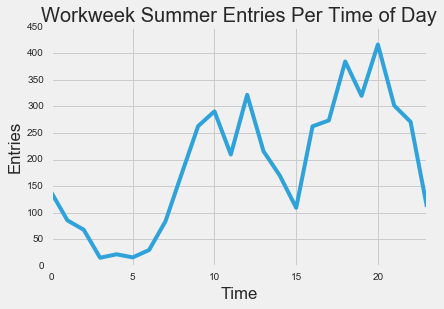

In [323]:
_ = final_data[(final_data.weekend == 0) & (final_data.season == 'Summer') ]\
            .groupby('time_int').mean()['abs_net_entries'].plot()
plt.title('Workweek Summer Entries Per Time of Day')
plt.xlabel('Time')
plt.ylabel('Entries')
print ''

<b> Traffic peaks when people enter work at around 8 and leave work at around 7

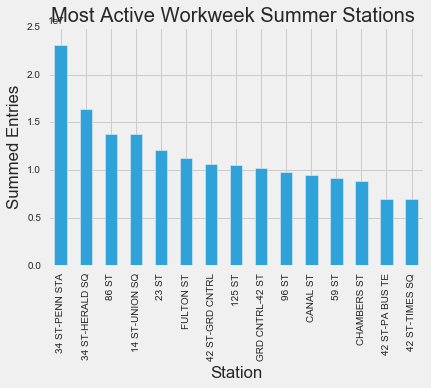

In [331]:
final_data[(final_data.weekend == 0) & (final_data.season == 'Summer')]\
            .groupby('station').sum().sort_values(by = 'abs_net_entries', ascending = False)\
            ['abs_net_entries'].head(15).plot('bar')
plt.title('Most Active Workweek Summer Stations ')
plt.xlabel('Station')
plt.ylabel('Summed Entries')
print ''

## Entries for Top 5 Stations

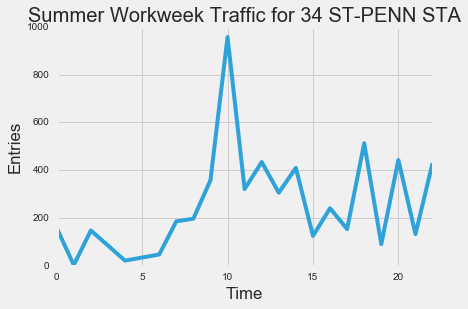

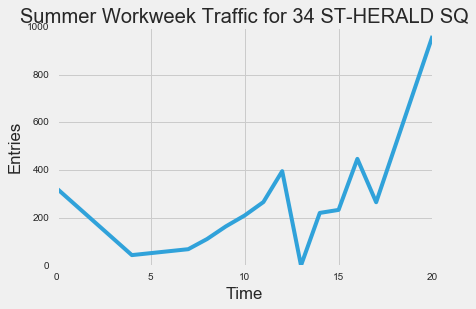

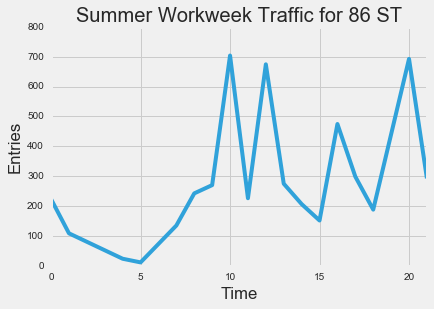

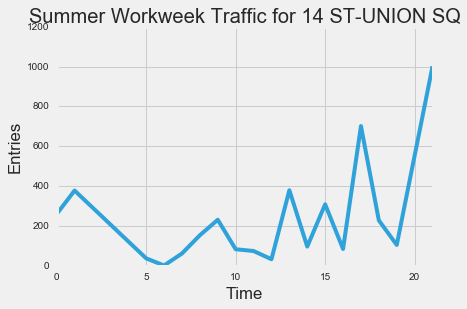

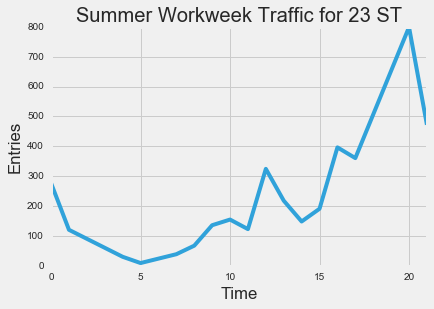

In [353]:
x = final_data[(final_data.weekend == 0) & (final_data.season == 'Summer')]\
            .groupby('station').sum().sort_values(by = 'abs_net_entries', ascending = False)\
            ['abs_net_entries'].head(5)
for i in x.index:
    final_data[(final_data.station == i)& (final_data.weekend == 0)& (final_data.season == 'Summer')]\
            .groupby('time_int').mean()['abs_net_entries'].plot()
    plt.title('Summer Workweek Traffic for ' + i)
    plt.xlabel('Time')
    plt.ylabel('Entries')
    plt.show()
    print ''

# Weekends

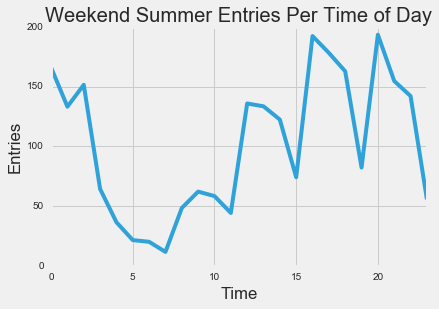

In [339]:
_ = final_data[(final_data.weekend == 1) & (final_data.season == 'Summer') ]\
            .groupby('time_int').mean()['abs_net_entries'].plot()
plt.title('Weekend Summer Entries Per Time of Day')
plt.xlabel('Time')
plt.ylabel('Entries')
print ''

<b> Unlike the Workweek with two weeks there is is an increasing amount of traffic during the evening. It increases
until 8 at night.

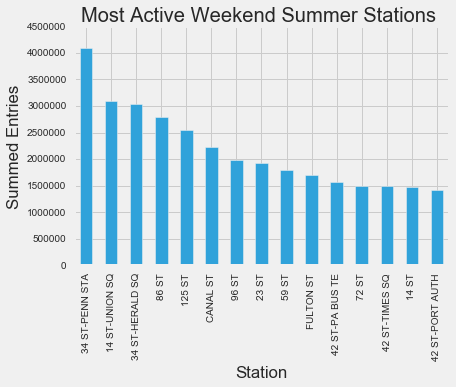

In [345]:
final_data[(final_data.weekend == 1) & (final_data.season == 'Summer')]\
            .groupby('station').sum().sort_values(by = 'abs_net_entries', ascending = False)\
            ['abs_net_entries'].head(15).plot('bar')
plt.title('Most Active Weekend Summer Stations ')
plt.xlabel('Station')
plt.ylabel('Summed Entries')
print ''

## Top 5 Stations for Weekends

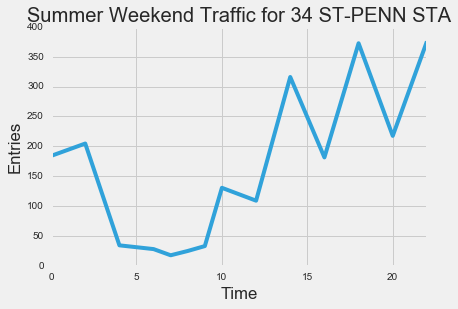

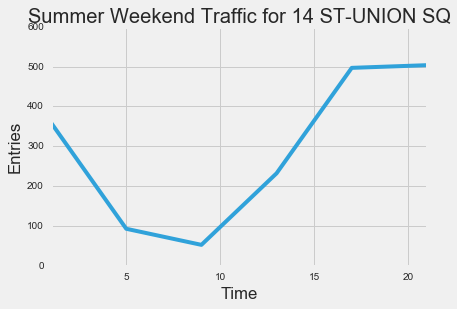

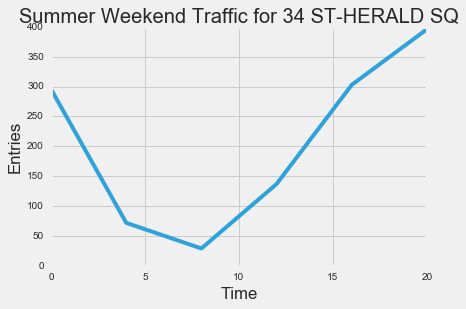

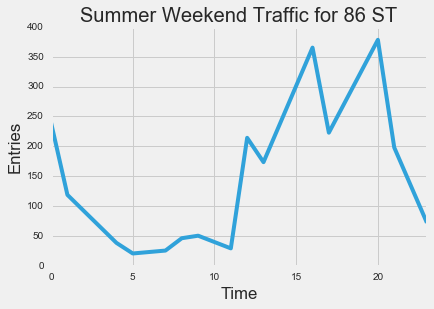

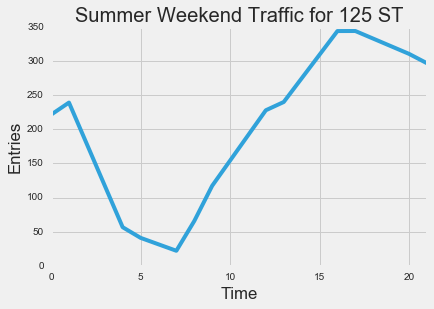

In [351]:
x = final_data[(final_data.weekend == 1) & (final_data.season == 'Summer')]\
            .groupby('station').sum().sort_values(by = 'abs_net_entries', ascending = False)\
            ['abs_net_entries'].head(5)
for i in x.index:
    final_data[(final_data.station == i)& (final_data.weekend == 1)& (final_data.season == 'Summer')]\
            .groupby('time_int').mean()['abs_net_entries'].plot()
    plt.title('Summer Weekend Traffic for ' + i)
    plt.xlabel('Time')
    plt.ylabel('Entries')
    plt.show()
    print ''
   

# Conclusions

1. So we see that the same stations show up for weekends and for the workweeks with 125st being the exception.
2. During the workweek the best times are during the morning around 8.am and later during the day around 6 p.m.. When people go to work and when they leave.
3. During the weekends it the best times are around the afternoon from noon to the evening. 
4. This does not take into account whether traffic is from tourists or not.

# Future Work

1. Narrow down to stations with tech savy populations.
2. Include data with high earning populations

# Extra Exploration for Fun

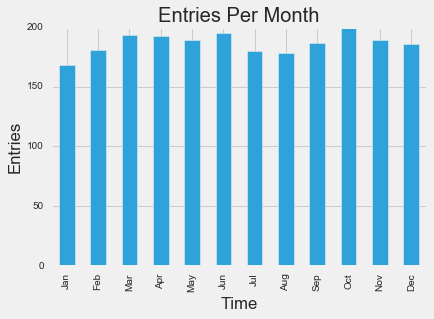

In [355]:
months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
final_data.groupby('month').mean()['abs_net_entries'][months].plot(kind = 'bar')
plt.title('Entries Per Month')
plt.xlabel('Time')
plt.ylabel('Entries')
print ''

<b> There seems to be no difference depending on the month </b>

## Weekend and Workweek Traffic Depending on the Weather

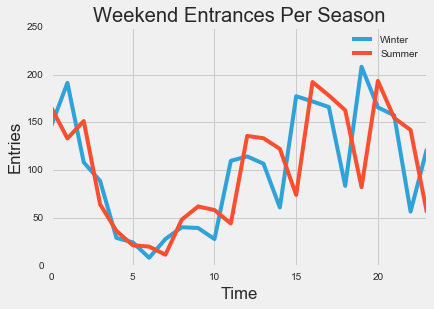

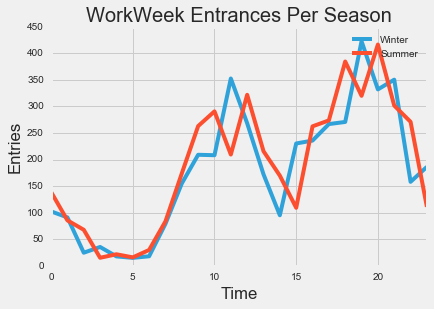

In [358]:
_ = final_data[(final_data.weekend == 1) & (final_data.season == 'Winter')]\
            .groupby('time_int').mean()['abs_net_entries'].plot(label = 'Winter')
_ = final_data[(final_data.weekend == 1) & (final_data.season == 'Summer')]\
            .groupby('time_int').mean()['abs_net_entries'].plot(label = 'Summer')
    
plt.legend()
_ = plt.title('Weekend Entrances Per Season')
plt.legend()
plt.title('Weekend Entrances Per Season')
plt.xlabel('Time')
plt.ylabel('Entries')
plt.show()
print ''

_ = final_data[(final_data.weekend == 0) & (final_data.season == 'Winter')]\
            .groupby('time_int').mean()['abs_net_entries'].plot(label = 'Winter')
_ = final_data[(final_data.weekend == 0) & (final_data.season == 'Summer')]\
            .groupby('time_int').mean()['abs_net_entries'].plot(label = 'Summer')
    

plt.legend()
plt.title('WorkWeek Entrances Per Season')
plt.xlabel('Time')
plt.ylabel('Entries')
plt.show()
print ''

<b>During the Warmer Weather there are lower peaks but they strench over the longer time. In the winter people are just trying to go in and out and not lingering as much as in summer

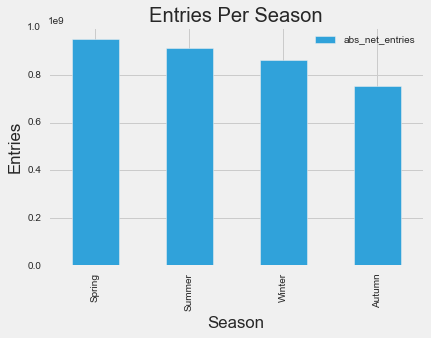

In [360]:
final_data.groupby('season').sum().sort_values(by = 'abs_net_entries', ascending = False)\
            ['abs_net_entries'].plot('bar')
plt.legend()
plt.title('Entries Per Season')
plt.xlabel('Season')
plt.ylabel('Entries')
plt.show()
print ''

<b> The warmer seasons get more traffic, with autumn getting the least amount of entries